Импорты

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from imageio import imread
from skimage.color import rgb2gray, label2rgb
from skimage.filters import gaussian, try_all_threshold, threshold_otsu, sobel 
from skimage.segmentation import watershed
from skimage.morphology import binary_opening, binary_closing, binary_erosion
from skimage import measure
from skimage.feature import canny
from skimage.measure import regionprops, ransac, label as sk_measure_label, regionprops
from scipy import ndimage as ndi

Выделяем маску на изображении

In [2]:
def get_mask_from_image(image):
    gaussian_sigma = 1.5
    
    img_gray = rgb2gray(image)
    img_gray_blur = gaussian(img_gray, sigma=gaussian_sigma, channel_axis=2)

    thresh_img = threshold_otsu(img_gray_blur)
    res_image = img_gray_blur <= thresh_img
    res_image = binary_opening(res_image, footprint=np.ones((5, 5)))
    mask = get_largest_component_in_center(res_image)
    mask = ndi.binary_fill_holes(mask)
    
    canny_sigma = 0.6
    canny_low_threshold = 0.4
    canny_high_threshold = 0.5
    binary_closing_footprint_width = 4
    binary_closing_footprint = np.ones((binary_closing_footprint_width, binary_closing_footprint_width))

    my_edge_map = binary_closing(
        canny(
            mask,
            sigma=canny_sigma,
            low_threshold=canny_low_threshold,
            high_threshold=canny_high_threshold,
        ),
        footprint=binary_closing_footprint
    )
    correct_mask_borders_after_canny(my_edge_map)
    my_edge_segmentation = ndi.binary_fill_holes(my_edge_map)
    res_image = my_edge_segmentation

#     canny_edge_map = binary_closing(canny(mask, sigma=1), footprint=np.ones((4, 4)))
#     correct_mask_borders_after_canny(canny_edge_map)
#     image_edge_segmentation = ndi.binary_fill_holes(canny_edge_map)    
    return res_image

def correct_mask_borders_after_canny(canny_result, border_width=3):
    canny_result[:border_width,:] = 0
    canny_result[:,:border_width] = 0
    canny_result[-border_width:,:] = 0
    canny_result[:,-border_width:] = 0

def get_largest_component_in_center(mask):
    labels = sk_measure_label(mask) 
    props = regionprops(labels)
    center = (mask.shape[0] / 2, mask.shape[1] / 2)
    dist = np.array([pow(center[0] - p.centroid[0], 2) + pow(center[1] - p.centroid[1], 2) for p in props])
    mask_id = dist.argmin()
    return (labels == (mask_id + 1))

Открываем изображения, достаём маску

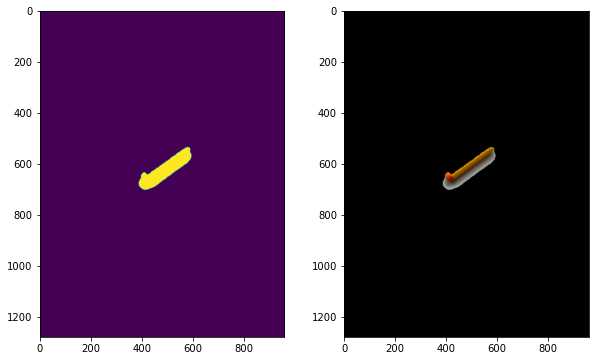

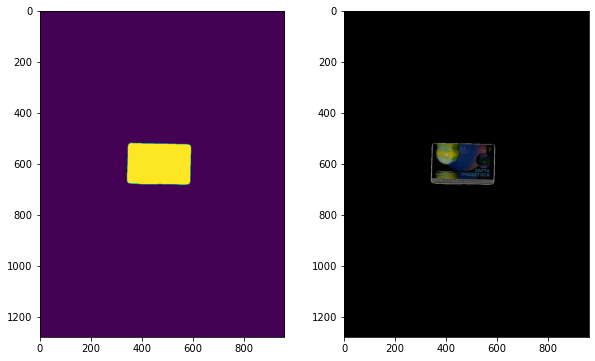

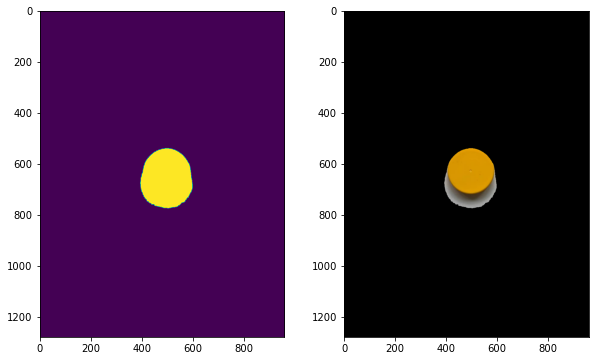

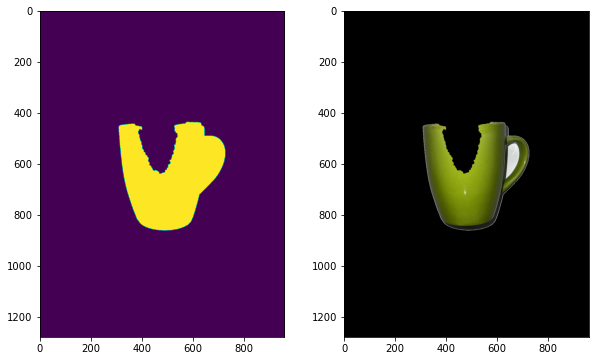

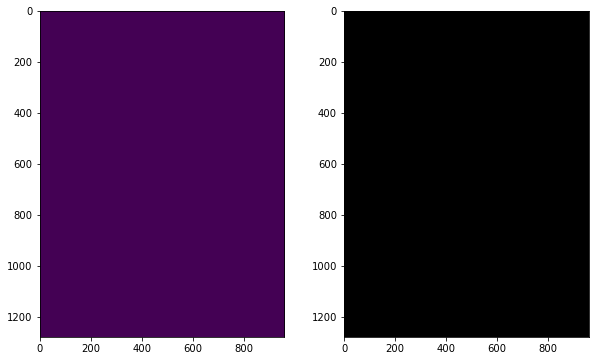

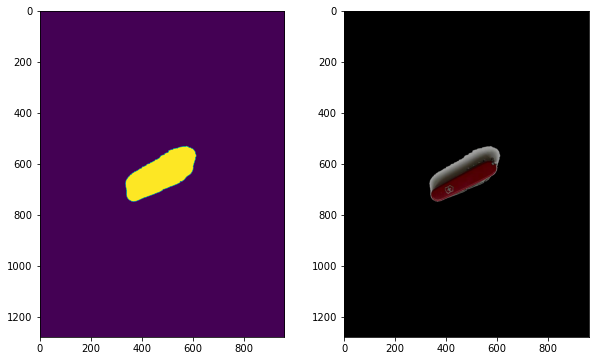

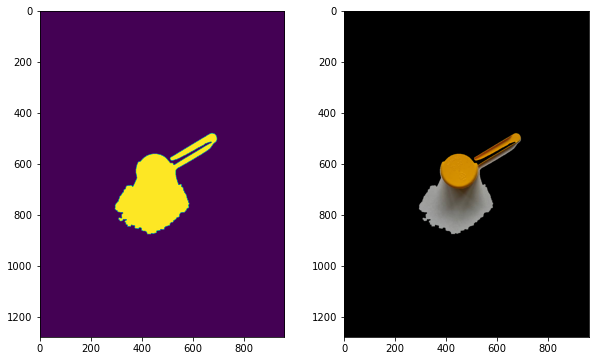

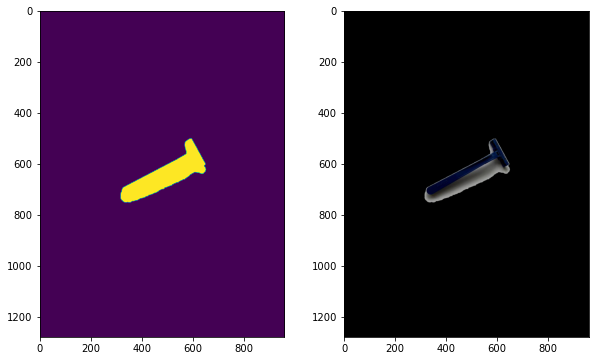

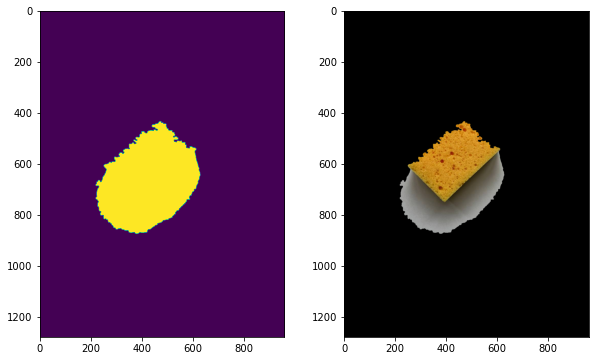

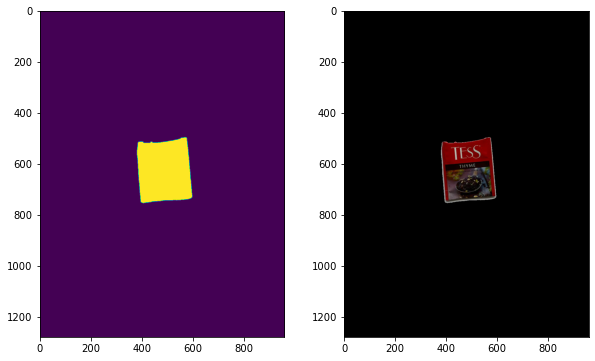

In [3]:
folder_path = "objects"
for image_path in os.listdir(folder_path):
    image_file = os.path.join(folder_path, image_path)
    image = imread(image_file);
    mask = get_mask_from_image(image);

    v_mask = (mask * 255).astype("uint8")
    result_image = cv2.bitwise_and(image, image, mask=v_mask)

    ig, ax = plt.subplots(1, 2, figsize=(10, 6))
    ax[0].imshow(mask)
    ax[1].imshow(result_image)
